Download Dataset: https://drive.google.com/file/d/1tedoFTFFBbM2iUvdg37WQFSq07ghYrll/view?usp=drive_link

### Steps to follow
1. Grouping .csv datas by emotion labels
2. Generating images from pixel values
3. Clarifying dataset by detecting faces and removing noises
4. Resizing images to the same dimentions
5. Normalize pixel values
6. Analysis dataset
7. Plot analyses
8. Split dataset to Test and Train

### Add Libraries

In [2]:
import pandas as pd
import os
import math
import numpy as np
import base64
from PIL import Image
import io
import cv2
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split


### Group Data

In [3]:
# load CSV file
data = pd.read_csv('../data/dataset.csv', skiprows=1)

# create destination directory
root_save_path = '../data/dataset/'
if not os.path.exists(root_save_path):
    os.makedirs(root_save_path)

# group images by lable
grouped = data.groupby(data.columns[0])

# extract and save data by in defferent directories
for label, group in grouped:
    label_save_path = os.path.join(root_save_path, str(label))
    if not os.path.exists(label_save_path):
        os.makedirs(label_save_path)
    csv_file_path = os.path.join(label_save_path, f'label_{label}.csv')
    group.to_csv(csv_file_path, header=False, index=False)


### Make Images

In [3]:
def load_data(filepath):
    """Load CSV data into a DataFrame."""
    return pd.read_csv(filepath)

for label in range(7):
    # load CSV data
    data = pd.read_csv(f'../data/dataset/{label}/label_{label}.csv', skiprows=1)

    save_path = f'../data/dataset/{label}/image_files'
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    # read dataset.csv data {lable, pixcels}
    for index, row in data.iterrows():
        pixels = row.iloc[1].split(' ')
        pixels = list(map(int, pixels))
        
        # calculate image real sizes
        image_size = int(math.sqrt(len(pixels)))
        image_array = np.array(pixels, dtype=np.uint8).reshape((image_size, image_size))
        
        # creat image and save
        image = Image.fromarray(image_array)
        image.save(os.path.join(save_path, f'label_{label}_index_{index}.png'))

KeyboardInterrupt: 

### Clarify Dataset

In [ ]:
def calculate_clarity(image_path, save_path, face_cascade):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale for face detection

    # Detect faces in the image
    faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=0)

    if len(faces) > 0:
        # Assuming only one face is detected (you can modify this for multiple faces)
        x, y, w, h = faces[0]

        # Calculate face area and total image area
        face_area = w * h
        total_image_area = image.shape[0] * image.shape[1]

        # Calculate noise percentage
        clarity_percentage = (face_area / total_image_area) * 100

        # Crop the image to keep only the detected face region
        face_image = image[y:y+h, x:x+w]

        # Add clarity percentage to the image file name
        new_filename = f"{filename.split('.')[0]}_{clarity_percentage:.2f}.png"
        new_image_path = os.path.join(save_path, new_filename)
        cv2.imwrite(new_image_path, face_image)  # Save the cropped face image
        os.remove(image_path)  # Remove the original image

        #print(f"Renamed and cropped: {filename} -> {new_filename}")
        return 0
    else:
        #print(f"No face detected in {filename}")
        return 1

# Load your face detection model (e.g., OpenCV's Haarcascades or a deep learning-based model)
# For example:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
noise_number=[]
# Assuming you have already loaded the images
for label in range(7):
    noise_number.append(0)
    image_folder = f'../data/dataset/{label}/image_files'
    save_path = f'../data/dataset/{label}/validated_images'
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for filename in os.listdir(image_folder):
        if filename.endswith(".png"):
            image_path = os.path.join(image_folder, filename)
            noise_number[label]+=calculate_clarity(image_path, save_path, face_cascade)
    print(f'{noise_number[label]} detected for group {label}')
print("Clarity sets for the datas succesfully")

### Resize Images

In [36]:
# Define a function to resize images to 128x128
def resize_images_in_place(folder_path, size=(128, 128)):
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        
        # Read images ans resize
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, size, interpolation=cv2.INTER_AREA)
        
        # Replace original images with the resized ones
        cv2.imwrite(image_path, resized_image)
        #print(f"Image {image_name} resized and replaced")

for label in range(7):
    # Define the source and destination image folder paths
    folder_path = f'../data/dataset/{label}/validated_images'

    # Resize images and save
    resize_images_in_place(folder_path)

# Print a success message
print("Images have been succesfully resized and saved to the new path.")

Images have been succesfully resized and saved to the new path.


### Normalize from 0-255 to 0-1

In [37]:
# Define a function to normalize pixel values of images in a folder
def normalize_image_pixels(folder_path):
    for image_name in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_name)
        
        # Read the image
        image = cv2.imread(image_path)
        # Normalize pixel values to [0, 1]
        normalized_image = image / 255.0
        
        # Save the normalized image
        cv2.imwrite(image_path, (normalized_image * 255).astype(np.uint8))
        #print(f"Normalized pixel values of {image_name}.")

for label in range(7):
    # Define the folder path containing the images to be normalized
    folder_path = f'../data/dataset/{label}/validated_images'

    # Normalize pixel values of the images
    normalize_image_pixels(folder_path)

# Print a success message
print("Pixel values of all images have been normalized.")

Normalized pixel values of label_0_index_0_66.02.png.
Normalized pixel values of label_0_index_1002_25.00.png.
Normalized pixel values of label_0_index_1004_80.25.png.
Normalized pixel values of label_0_index_1005_80.25.png.
Normalized pixel values of label_0_index_1006_66.02.png.
Normalized pixel values of label_0_index_1007_66.02.png.
Normalized pixel values of label_0_index_1008_44.44.png.
Normalized pixel values of label_0_index_1009_66.02.png.
Normalized pixel values of label_0_index_1010_53.17.png.
Normalized pixel values of label_0_index_1011_44.44.png.
Normalized pixel values of label_0_index_1013_25.00.png.
Normalized pixel values of label_0_index_1014_25.00.png.
Normalized pixel values of label_0_index_1015_53.17.png.
Normalized pixel values of label_0_index_1016_44.44.png.
Normalized pixel values of label_0_index_1017_29.34.png.
Normalized pixel values of label_0_index_1018_66.02.png.
Normalized pixel values of label_0_index_101_66.02.png.
Normalized pixel values of label_0_

### Analyze Dataset

In [44]:
# Define the base path for the dataset
base_path = '../data/dataset'

# Initialize statistics dictionary
statistics = {
    'total_images': 0,
    'images_per_class': {},
    'noise_per_class': {}
}

# Function to calculate the noise of an image
def calculate_image_noise(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return cv2.Laplacian(image, cv2.CV_64F).var()

# Gather statistics
for class_folder in os.listdir(base_path):
    class_path = os.path.join(base_path, class_folder)
    validated_images_path = os.path.join(class_path, 'validated_images')
    
    # Skip if not a directory
    if not os.path.isdir(validated_images_path):
        continue
    
    # Initialize class statistics
    statistics['images_per_class'][class_folder] = 0
    
    # Iterate over images in each class
    for image_name in os.listdir(validated_images_path):
        image_path = os.path.join(validated_images_path, image_name)
        
        # Update total images count
        statistics['total_images'] += 1
        
        # Update images per class count
        statistics['images_per_class'][class_folder] += 1
        
    statistics['noise_per_class'][class_folder] = noise_number[int(class_folder)] / statistics['images_per_class'][class_folder] * 100


# Print the gathered statistics
print(f"Total number of images: {statistics['total_images']}")
for class_folder, count in statistics['images_per_class'].items():
    print(f"Number of images in class {class_folder}: {count}")
    print(f"Noise images in class {class_folder}: {statistics['noise_per_class'][class_folder]:.2f}")

# Print the distribution of classes
print("Distribution of classes:")
for class_folder, count in statistics['images_per_class'].items():
    distribution = (count / statistics['total_images']) * 100
    print(f"Class {class_folder}: {distribution:.2f}%")


Total number of images: 23620
Number of images in class 0: 3211
Noise images in class 0: 54.16
Number of images in class 1: 348
Noise images in class 1: 56.61
Number of images in class 2: 3090
Noise images in class 2: 65.66
Number of images in class 3: 6330
Noise images in class 3: 41.97
Number of images in class 4: 3215
Noise images in class 4: 88.96
Number of images in class 5: 2863
Noise images in class 5: 39.71
Number of images in class 6: 4563
Noise images in class 6: 35.79
Distribution of classes:
Class 0: 13.59%
Class 1: 1.47%
Class 2: 13.08%
Class 3: 26.80%
Class 4: 13.61%
Class 5: 12.12%
Class 6: 19.32%


### Plot Analyses

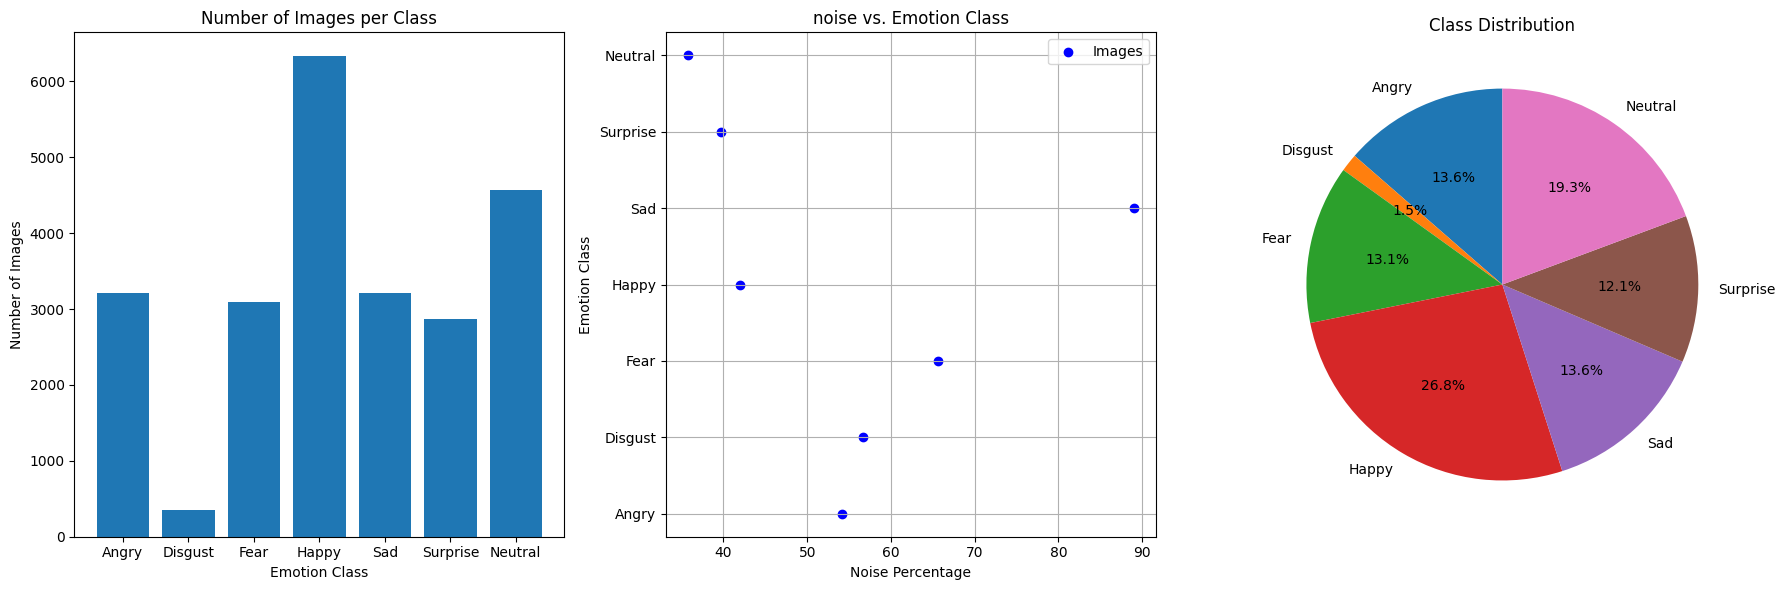

In [48]:
# Data for plotting
class_names = list(statistics['images_per_class'].keys())
image_counts = list(statistics['images_per_class'].values())
noise_percentage = list(statistics['noise_per_class'].values())

# Create a dictionary to map class numbers to class names
class_mapping = {
    '0': 'Angry',
    '1': 'Disgust',
    '2': 'Fear',
    '3': 'Happy',
    '4': 'Sad',
    '5': 'Surprise',
    '6': 'Neutral'
}

# Replace numeric class labels with class names
class_names_display = [class_mapping[class_name] for class_name in class_names]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Bar plot: Number of images per class
axs[0].bar(class_names_display, image_counts)
axs[0].set_title('Number of Images per Class')
axs[0].set_xlabel('Emotion Class')
axs[0].set_ylabel('Number of Images')

# Scatter plot: noise vs. Emotion Class
axs[1].scatter(noise_percentage, class_names_display, color='b', marker='o', label='Images')
axs[1].set_xlabel('Noise Percentage')
axs[1].set_ylabel('Emotion Class')
axs[1].set_title('noise vs. Emotion Class')
axs[1].grid(True)
axs[1].legend()

# The rest of the code remains unchanged.


# Pie chart: Class distribution
axs[2].pie(image_counts, labels=class_names_display, autopct='%1.1f%%', startangle=90)
axs[2].set_title('Class Distribution')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

### Split Test And Train

In [49]:
# Define the base path for the dataset
base_path = '../data'

# Lists to store file paths and labels
file_paths = []
labels = []

# Collect file paths and labels
for label in range(7):
    class_path = os.path.join(base_path, 'dataset', str(label), 'validated_images')
    for image_name in os.listdir(class_path):
        file_paths.append(os.path.join(class_path, image_name))
        labels.append(label)

# Convert lists to arrays
X = np.array(file_paths)
y = np.array(labels)

# Split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define directories for saving training and testing images
train_dir = os.path.join(base_path, 'train')
test_dir = os.path.join(base_path, 'test')

# Create directories if they don't exist
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Function to copy files to the new directories
def copy_files(file_paths, labels, destination_dir):
    for i, file_path in enumerate(file_paths):
        # Create subdirectories for each label if they don't exist
        label_dir = os.path.join(destination_dir, str(labels[i]))
        if not os.path.exists(label_dir):
            os.makedirs(label_dir)
        
        # Copy the file to the new directory
        shutil.copy(file_path, label_dir)
        #print(f"File {os.path.basename(file_path)} copied to {label_dir}.")

# Copy training and testing images to the respective directories
copy_files(X_train, y_train, train_dir)
copy_files(X_test, y_test, test_dir)

# Print a success message
print("Images have been successfully split into training and testing subsets and saved in the corresponding directories.")
